In [1]:
// Getting Contours From TH2D
// Author: Josh de Bever
//         CSI Medical Physics Group
//         The University of Western Ontario
//         London, Ontario, Canada
//   Date: Oct. 22, 2004
//   Modified by O.Couet (Nov. 26, 2004)

Double_t SawTooth(Double_t x, Double_t WaveLen){

// This function is specific to a sawtooth function with period
// WaveLen, symmetric about x = 0, and with amplitude = 1. Each segment
// is 1/4 of the wavelength.
//
//           |
//      /\   |
//     /  \  |
//    /    \ |
//   /      \
//  /--------\--------/------------
//           |\      /
//           | \    /
//           |  \  /
//           |   \/
//

   Double_t y;
   if ( (x < -WaveLen/2) || (x > WaveLen/2)) y = -99999999; // Error X out of bounds
   if (x <= -WaveLen/4) {
      y = x + 2.0;
   } else if ((x > -WaveLen/4) && (x <= WaveLen/4)) {
      y = -x ;
   } else if (( x > WaveLen/4) && (x <= WaveLen/2)) {
      y = x - 2.0;
   }
   return y;
}

In [2]:
TCanvas *ContourList(){

   const Double_t PI = TMath::Pi();

   TCanvas* c = new TCanvas("c","Contour List",0,0,600,600);
   c->SetRightMargin(0.15);
   c->SetTopMargin(0.15);

   Int_t i, j;

   Int_t nZsamples   = 80;
   Int_t nPhiSamples = 80;

   Double_t HofZwavelength = 4.0;       // 4 meters
   Double_t dZ             =  HofZwavelength/(Double_t)(nZsamples - 1);
   Double_t dPhi           = 2*PI/(Double_t)(nPhiSamples - 1);

   TArrayD z(nZsamples);
   TArrayD HofZ(nZsamples);
   TArrayD phi(nPhiSamples);
   TArrayD FofPhi(nPhiSamples);

   // Discretized Z and Phi Values
   for ( i = 0; i < nZsamples; i++) {
      z[i] = (i)*dZ - HofZwavelength/2.0;
      HofZ[i] = SawTooth(z[i], HofZwavelength);
   }

   for(Int_t i=0; i < nPhiSamples; i++){
      phi[i] = (i)*dPhi;
      FofPhi[i] = sin(phi[i]);
   }

   // Create Histogram
   TH2D *HistStreamFn = new TH2D("HstreamFn",
   "#splitline{Histogram with negative and positive contents. Six contours are defined.}{It is plotted with options CONT LIST to retrieve the contours points in TGraphs}",
   nZsamples, z[0], z[nZsamples-1], nPhiSamples, phi[0], phi[nPhiSamples-1]);

   // Load Histogram Data
   for (Int_t i = 0; i < nZsamples; i++) {
      for(Int_t j = 0; j < nPhiSamples; j++){
         HistStreamFn->SetBinContent(i,j, HofZ[i]*FofPhi[j]);
      }
   }

   gStyle->SetPalette(1);
   gStyle->SetOptStat(0);
   gStyle->SetTitleW(0.99);
   gStyle->SetTitleH(0.08);

   Double_t contours[6];
   contours[0] = -0.7;
   contours[1] = -0.5;
   contours[2] = -0.1;
   contours[3] =  0.1;
   contours[4] =  0.4;
   contours[5] =  0.8;

   HistStreamFn->SetContour(6, contours);

   // Draw contours as filled regions, and Save points
   HistStreamFn->Draw("CONT Z LIST");
   c->Update(); // Needed to force the plotting and retrieve the contours in TGraphs

   // Get Contours
   TObjArray *conts = (TObjArray*)gROOT->GetListOfSpecials()->FindObject("contours");
   TList* contLevel = NULL;
   TGraph* curv     = NULL;
   TGraph* gc       = NULL;

   Int_t nGraphs    = 0;
   Int_t TotalConts = 0;

   if (conts == NULL){
      printf("*** No Contours Were Extracted!\n");
      TotalConts = 0;
      return 0;
   } else {
      TotalConts = conts->GetSize();
   }

   printf("TotalConts = %d\n", TotalConts);

   for(i = 0; i < TotalConts; i++){
      contLevel = (TList*)conts->At(i);
      printf("Contour %d has %d Graphs\n", i, contLevel->GetSize());
      nGraphs += contLevel->GetSize();
   }

   nGraphs = 0;

   TCanvas* c1 = new TCanvas("c1","Contour List",610,0,600,600);
   c1->SetTopMargin(0.15);
   TH2F *hr = new TH2F("hr",
   "#splitline{Negative contours are returned first (highest to lowest). Positive contours are returned from}{lowest to highest. On this plot Negative contours are drawn in red and positive contours in blue.}",
   2, -2, 2, 2, 0, 6.5);

   hr->Draw();
   Double_t x0, y0, z0;
   TLatex l;
   l.SetTextSize(0.03);
   char val[20];

   for(i = 0; i < TotalConts; i++){
      contLevel = (TList*)conts->At(i);
      if (i<3) z0 = contours[2-i];
      else     z0 = contours[i];
      printf("Z-Level Passed in as:  Z = %f\n", z0);

      // Get first graph from list on curves on this level
      curv = (TGraph*)contLevel->First();
      for(j = 0; j < contLevel->GetSize(); j++){
         curv->GetPoint(0, x0, y0);
         if (z0<0) curv->SetLineColor(kRed);
         if (z0>0) curv->SetLineColor(kBlue);
         nGraphs ++;
         printf("\tGraph: %d  -- %d Elements\n", nGraphs,curv->GetN());

         // Draw clones of the graphs to avoid deletions in case the 1st
         // pad is redrawn.
         gc = (TGraph*)curv->Clone();
         gc->Draw("C");

         sprintf(val,"%g",z0);
         l.DrawLatex(x0,y0,val);
         curv = (TGraph*)contLevel->After(curv); // Get Next graph
      }
   }
   c1->Update();
   printf("\n\n\tExtracted %d Contours and %d Graphs \n", TotalConts, nGraphs );
   gStyle->SetTitleW(0.);
   gStyle->SetTitleH(0.);
   return c1;
}


In [3]:
a=ContourList()

TotalConts = 6
Contour 0 has 2 Graphs
Contour 1 has 2 Graphs
Contour 2 has 2 Graphs
Contour 3 has 2 Graphs
Contour 4 has 2 Graphs
Contour 5 has 2 Graphs
Z-Level Passed in as:  Z = -0.100000
	Graph: 1  -- 147 Elements
	Graph: 2  -- 147 Elements
Z-Level Passed in as:  Z = -0.500000
	Graph: 3  -- 93 Elements
	Graph: 4  -- 93 Elements
Z-Level Passed in as:  Z = -0.700000
	Graph: 5  -- 65 Elements
	Graph: 6  -- 65 Elements
Z-Level Passed in as:  Z = 0.100000
	Graph: 7  -- 147 Elements
	Graph: 8  -- 147 Elements
Z-Level Passed in as:  Z = 0.400000
	Graph: 9  -- 107 Elements
	Graph: 10  -- 107 Elements
Z-Level Passed in as:  Z = 0.800000
	Graph: 11  -- 49 Elements
	Graph: 12  -- 49 Elements


	Extracted 6 Contours and 12 Graphs 
(TCanvas *) @0x7fcdb10a86b8


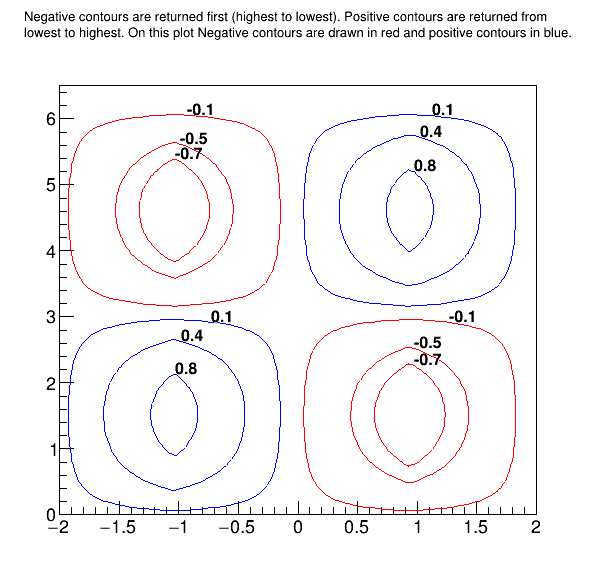

In [4]:
a->Draw()